# User Classificationwith python and Scikit-Learn.¶

This Notebook will perform the following tasks:

* Clean Twitter description data. This functionality (and how exactly we will clean/prepare our raw data can be seen in the clean method in the second block
* Test the following models on our dataset:
       * Random Forest
       * Logistic Regression
       * Support Vector Machine (linear kernel)
       * Naive Bayes (Multinomial and Gaussian priors)
Save the results of each model to a well-formatted csv file
Evaluate the models automatically and save the results to a csv file

##  imports all the necessary packages

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, csv
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC

## write function to clean data

In [38]:
def clean(string):
    letters_only = re.sub("[^a-zA-Z#@]", " ", string)

    words = letters_only.split()

    for i in range(0, len(words)):
        if "#" in words[i]:
            s = words[i].split('#')
            words[i] = '# '.join(s)
        if "@" in words[i]:
            s = words[i].split('@')
            words[i] = '@ '.join(s)
        if "http" in words[i]:
            s = words[i].split('http')
            words[i]= "http".join(s)
            
    total_stop_words = set(stopwords.words("english"))
    removed_stop_words = set(stopwords.words("english")[0:20])
    stop_words = total_stop_words - removed_stop_words
    content_words = [w for w in words if not w in stop_words]

    return " ".join(content_words)

def read_data(data):
    data['description'] = data.apply(lambda row: clean(row['description']), axis = 1)
    level_mapping = {'general': 0, 'private': 1, 'NGO': 2, 'government':3}
    data['group'] = data.apply(lambda row:data['group'].replace(level_mapping))
    return data[['description','group']]

def eval_model(name, classes, predictions):
    TP, TN, FP, FN = 0, 0, 0, 0
    classes = list(classes)
    predictions = list(predictions)
    
    for i in range(0,len(classes)):
        if (classes[i] == 1) & (predictions[i] == 1):
            TP += 1
        if (classes[i] == 0) & (predictions[i] == 0):
            TN += 1
        if (classes[i] == 1) & (predictions[i] == 0):
            FN += 1
        if (classes[i] == 0) & (predictions[i] == 1):
            FP += 1
   
    accuracy= (TP + TN)/(TP + TN + FP + FN)
    precision= (TP)/(TP+FP)
    recall= TP / (TP+FN)
    f_one= 2 * (precision*recall)/(precision + recall)
    
    scores = {
        'Model Name': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f_one,
        'Total TP type':TP,
        'Total TN type':TN,
        'Total FP type':FP,
        'Total FN type':FN
    }
    
    return scores

## load the data into pandas Dataframes

In [11]:
k_user = pd.read_csv("data/kenyan_users_grouped - kenyan_users.csv")
n_user = pd.read_csv("data/nigerian_users_grouped - nigerian_users.csv")
s_user = pd.read_csv("data/south_african_user_grouped - south_african_user.csv")

In [12]:
k_user.head()

,Unnamed: 0,user_id,name,screen_name,description,group,followers_count,verified
0,0,1.150743e+18,ChezaKe,KeCheza,"NEWBUZZ\nTAG,DM or📧ChezaKe100@gmail.com \nBook...",private,1356.0,False
1,1,1.150743e+18,ChezaKe,KeCheza,"NEWBUZZ\nTAG,DM or📧ChezaKe100@gmail.com \nBook...",private,1356.0,False
2,2,2.616828e+09,Matt Lichti,mllichti,NaN,general,29.0,False
3,3,8.006929e+17,East Africa Watch,LugamboBlog,"Watching Uganda, Rwanda and Kenya",private,1548.0,False
4,4,1.028516e+18,Charles Henry K. Mangua,k_mangua,"Am a 'chosen and sent'. Am a Pastor, Evangelis...",general,1.0,False


In [13]:
n_user.head()

,Unnamed: 0,user_id,name,screen_name,description,group,followers_count,verified
0,0,4.755861e+08,mostarzy,mosesemanuel,"Book writer, African modelling,and contractor",general,76,False
1,1,9.131607e+07,Nigeria Newsdesk,NigeriaNewsdesk,Breaking news and current events from around N...,private,1739295,True
2,2,9.131607e+07,Nigeria Newsdesk,NigeriaNewsdesk,Breaking news and current events from around N...,private,1739295,True
3,3,2.483954e+09,TODAY,todayng,"Latest news, trends, photos and videos from ar...",private,193604,True
4,4,7.764142e+08,saintanthony,staintanthony,We fight not for glory nor for wealth nor hono...,general,1670,False


In [14]:
s_user.head()

,Unnamed: 0,user_id,name,screen_name,description,group,followers_count,verified
0,0,3.542582e+08,welcome wxk khoza,welcomexk,"KAIZER CHIEFS, METHODIST CHURCH, ANC, ROTARY, ...",private,1702,False
1,1,3.283054e+09,The Mekong Eye,MekongEye,News-Maps-Perspectives-Solutions. Curated & or...,private,1581,False
2,2,3.292607e+09,Food Security SA,FoodSecurity_za,"An initiative of @dstgovza - @nrf_news, undert...",NGO,2386,False
3,3,1.931956e+08,Dr. Guendouzi ( The Cerebral Assassin ),fimiletoks,"Born Dec 27th..Baptist, Medical Doctor.. #Heal...",general,32716,False
4,4,1.043434e+18,#TeachersDay2020 Thank You Teacher,ngoamazing2009,"I'm your satisfaction & inspiration, taking yo...",private,3680,False


In [15]:
# Concatinate each country user 
all_user = pd.concat([k_user,n_user,s_user])

In [16]:
all_user.head()

,Unnamed: 0,user_id,name,screen_name,description,group,followers_count,verified
0,0,1.150743e+18,ChezaKe,KeCheza,"NEWBUZZ\nTAG,DM or📧ChezaKe100@gmail.com \nBook...",private,1356.0,False
1,1,1.150743e+18,ChezaKe,KeCheza,"NEWBUZZ\nTAG,DM or📧ChezaKe100@gmail.com \nBook...",private,1356.0,False
2,2,2.616828e+09,Matt Lichti,mllichti,NaN,general,29.0,False
3,3,8.006929e+17,East Africa Watch,LugamboBlog,"Watching Uganda, Rwanda and Kenya",private,1548.0,False
4,4,1.028516e+18,Charles Henry K. Mangua,k_mangua,"Am a 'chosen and sent'. Am a Pastor, Evangelis...",general,1.0,False


In [18]:
#drop unnecessary columns
all_user.drop(columns=['Unnamed: 0'],inplace=True)

In [19]:
all_user.head()

,user_id,name,screen_name,description,group,followers_count,verified
0,1.150743e+18,ChezaKe,KeCheza,"NEWBUZZ\nTAG,DM or📧ChezaKe100@gmail.com \nBook...",private,1356.0,False
1,1.150743e+18,ChezaKe,KeCheza,"NEWBUZZ\nTAG,DM or📧ChezaKe100@gmail.com \nBook...",private,1356.0,False
2,2.616828e+09,Matt Lichti,mllichti,NaN,general,29.0,False
3,8.006929e+17,East Africa Watch,LugamboBlog,"Watching Uganda, Rwanda and Kenya",private,1548.0,False
4,1.028516e+18,Charles Henry K. Mangua,k_mangua,"Am a 'chosen and sent'. Am a Pastor, Evangelis...",general,1.0,False


In [20]:
#checking for null data
all_user.isnull().sum()

user_id              0
name                 0
screen_name          1
description        822
group                1
followers_count      2
verified             2
dtype: int64

In [21]:
all_user.shape

(8580, 7)

In [22]:
#dropping all null values
all_user.dropna(inplace=True)

In [23]:
all_user.isnull().sum()

user_id            0
name               0
screen_name        0
description        0
group              0
followers_count    0
verified           0
dtype: int64

In [24]:
all_user.shape

(7756, 7)

In [32]:
#show count of all categories in group
all_user['group'].value_counts()

general       5958
private       1332
NGO            340
government     126
Name: group, dtype: int64

In [30]:
all_user = all_user.replace(" private", "private")
all_user = all_user.replace("nGO","NGO")

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

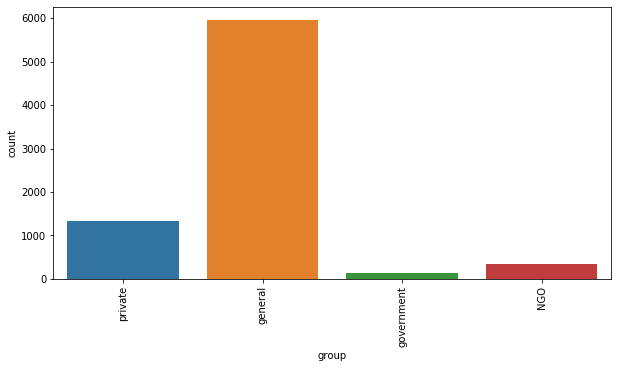

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(all_user['group'])
plt.xticks(rotation=90)

In [39]:
train_test = read_data(all_user)

In [40]:
train_test.head()

,description,group
0,NEWBUZZ TAG DM ChezaKe @ gmail com Book Studi...,1
1,NEWBUZZ TAG DM ChezaKe @ gmail com Book Studi...,1
3,Watching Uganda Rwanda Kenya,1
4,Am chosen sent Am Pastor Evangelist herald A m...,0
5,We connect communicate food secure future Foll...,3


In [41]:
train_test.shape

(7756, 2)

In [43]:
X = train_test['description']
y = train_test['group']

In [69]:
#spliting data to train and test with ratio of 9 to 1
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=0)

In [46]:
#vectorize the user descriptions (find a numerical coding for each text-based description)
v = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words= None, max_features=500)

In [47]:
train_vectors = v.fit_transform(X_train)
test_vectors = v.fit_transform(X_test)


# We will now build, train, and test our 5 models.

In [70]:
y_test = y_test.to_frame()
y_test = y_test.reset_index()


In [71]:
y_test.head()

,index,group
0,922,0
1,1063,0
2,987,0
3,3076,0
4,1461,1


### Logistic Regression

In [72]:
LR = LogisticRegression()
LR.fit(train_vectors, y_train)


LogisticRegression()

In [73]:
y_test['Logistic Regression Predictions'] = LR.predict(test_vectors)

### Random Forest Classifier

In [74]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(train_vectors, y_train)

y_test['Random Forest Predictions'] = RF.predict(test_vectors)

### Guassian Naive Bayes


In [75]:
GNB = GaussianNB()
GNB.fit(train_vectors.toarray(), y_train)

y_test['GaussianNB Predictions'] = GNB.predict(test_vectors.toarray())

### Multinomial Naive Bayes

In [76]:
MNB = MultinomialNB()
MNB.fit(train_vectors, y_train)

y_test['MultinomialNB Predictions'] = MNB.predict(test_vectors)

### Support Vector Machine

In [77]:
SVM = SVC(kernel = 'linear')
SVM.fit(train_vectors, y_train)

y_test['SVM Predictions'] = SVM.predict(test_vectors)

In [78]:
## Saving Model prediction
y_test.to_csv('data/results.csv', index=False)

In [79]:
y_test.head()

,index,group,Logistic Regression Predictions,Random Forest Predictions,GaussianNB Predictions,MultinomialNB Predictions,SVM Predictions
0,922,0,0,0,0,0,0
1,1063,0,0,0,1,0,0
2,987,0,1,1,0,0,1
3,3076,0,0,0,3,0,0
4,1461,1,0,0,0,0,0


## Let's construct a table that has the evaulation metrics of our models¶

In [80]:
ts = y_test

RF_metric = eval_model('RF', ts['group'], ts['Random Forest Predictions'])
LR_metric = eval_model('LR', ts['group'], ts['Logistic Regression Predictions'])
GNB_metric = eval_model('GNB', ts['group'], ts['GaussianNB Predictions'])
MNB_metric = eval_model('MNB', ts['group'], ts['MultinomialNB Predictions'])
SVM_metric = eval_model('SVM', ts['group'], ts['SVM Predictions'])

metrics_list = [ RF_metric, LR_metric, GNB_metric, MNB_metric, SVM_metric]
metrics = pd.DataFrame(metrics_list)

In [81]:
metrics

,Accuracy,F1 Score,Model Name,Precision,Recall,Total FN type,Total FP type,Total TN type,Total TP type
0,0.730028,0.222222,RF,0.269231,0.189189,120,76,502,28
1,0.768176,0.274678,LR,0.372093,0.217687,115,54,528,32
2,0.618117,0.390935,GNB,0.305310,0.543307,58,157,279,69
3,0.741110,0.208696,MNB,0.272727,0.169014,118,64,497,24
4,0.730663,0.148472,SVM,0.209877,0.114865,131,64,512,17
